In [1]:
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Load the data
complaints_file_path = 'shared/complaints_25Nov21.csv'
complaints_data = pd.read_csv(complaints_file_path)

# Display the first few rows of the dataframe for exploration
complaints_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647


In [3]:
# Perform EDA to understand the dataset better
# Check the distribution of the target variable 'Consumer disputed?'
target_distribution = complaints_data['Consumer disputed?'].value_counts(normalize=True)

# Check for missing values in the predictor variables
missing_values = complaints_data[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 
                                  'Submitted via', 'Company response to consumer', 'Timely response?']].isnull().sum()

target_distribution, missing_values

(Consumer disputed?
 No     0.783349
 Yes    0.216651
 Name: proportion, dtype: float64,
 Product                              0
 Sub-product                      43015
 Issue                                0
 State                             2194
 Tags                            178995
 Submitted via                        0
 Company response to consumer         0
 Timely response?                     0
 dtype: int64)

In [4]:
# Selecting the predictors as specified
predictor_columns = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']
X = complaints_data[predictor_columns]

# Handling missing values - You can choose to fill missing values with a placeholder value like 'Unknown'
X.fillna('Unknown', inplace=True)
X = pd.get_dummies(X, columns=predictor_columns)

# Encode the target variable 'Consumer disputed?'
le = LabelEncoder()
y = le.fit_transform(complaints_data['Consumer disputed?'])

/tmp/ipykernel_2151/3514649304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna('Unknown', inplace=True)


In [5]:
X.head()

,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,...,Submitted via_Web,Company response to consumer_Closed,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes
0,False,False,False,False,False,True,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
2,True,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,True
3,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [6]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Check the proportion of disputed complaints and undersample if necessary
dispute_rate = y_train.sum() / len(y_train)
if dispute_rate < 0.3:
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X, y)
    
# Check the proportion of disputes in the training dataset after undersampling
proportion_disputes = y_train.mean()
print(f"Proportion of disputes in the training dataset after undersampling: {proportion_disputes}")# One-hot encode categorical features


Proportion of disputes in the training dataset after undersampling: 0.5


In [7]:
#Q1
target_distribution_1 = sum(y_test)/ len(y_test)
target_distribution_1

0.21586413200810575

              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452

[[17353 15151]
 [ 3104  5844]]
17353
15151
3104
5844
Cost without the model: $8619200
Cost with the model: $7586750
Cost savings: $1032450


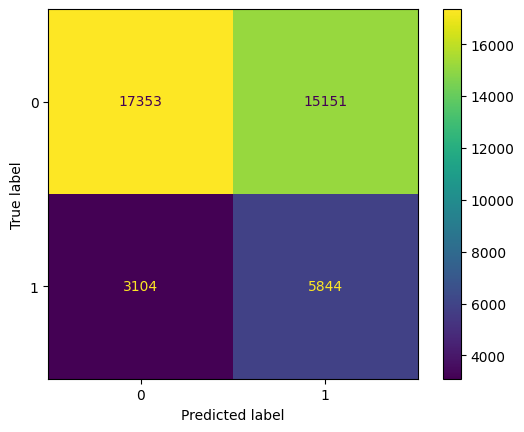

In [8]:
# Train the XGBoost Classifier
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = model_xgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test)


# Calculate the total cost without the model
cost_no_model = (y_test.sum() * 600) + ((len(y_test) - y_test.sum()) * 100)

# Correct the total cost calculation with the model
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn)
print(fp)
print(fn)
print(tp)
cost_with_model = (tp * (100 + 90)) + (fp * (100 + 90)) + (fn * 600) + (tn * 100)

# Calculate cost savings
cost_savings = cost_no_model - cost_with_model
print(f"Cost without the model: ${cost_no_model}")
print(f"Cost with the model: ${cost_with_model}")
print(f"Cost savings: ${cost_savings}")

In [9]:
# Predict the probabilities for the positive class (class 1)
y_probs = model_xgb.predict_proba(X_test)[:, 1]

# Define the cost function based on the problem statement
def calculate_cost(threshold, y_true, y_probs):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tp * (100 + 90)) + (fp * (100 + 90)) + (fn * 600) + (tn * 100)

# Initialize the minimum cost to a large number and the optimal threshold to None
min_cost = float('inf')
optimal_threshold = None

# Iterate over a range of thresholds to find the one that minimizes the total cost
for threshold in np.linspace(0, 1, 101):  # 101 points between 0 and 1, inclusive
    cost = calculate_cost(threshold, y_test, y_probs)
    if cost < min_cost:
        min_cost = cost
        optimal_threshold = threshold

# Output the optimal threshold and the corresponding cost
print(f"Optimal threshold: {optimal_threshold}")
print(f"Total cost at optimal threshold: ${min_cost}")

Optimal threshold: 0.46
Total cost at optimal threshold: $7491540


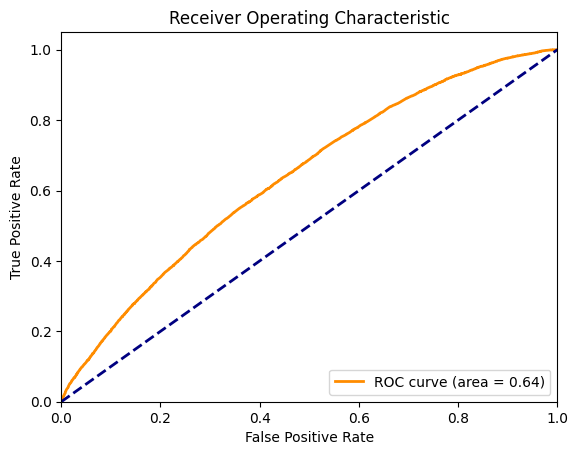

In [12]:
# Predict the probabilities for the positive class
y_pred_probs = model_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()